# Olist Seller Success - Core Business Insights Analysis

This script performs the second stage of the analysis, focusing on:
1. Geographic Analysis
2. Purchase Behavior Analysis (Repurchase & Market Basket)
3. Sentiment Analysis (Proxy Analysis)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
print("---'Loading Data'---")
# Load the processed dataset from Stage 1
df = pd.read_csv('data/olist_processed_dataset.csv')

# Load original datasets needed for specific analyses
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')

# Set plot style for all visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
print("Data loaded successfully.")


---'Loading Data'---
Data loaded successfully.



--- Starting Geographic Analysis ---
Displaying Geographic Analysis Plot...
Insights:
- Top-Right (High AOV, High Customers): Core markets like SP.
- Top-Left (High AOV, Low Customers): Potential markets with high-value customers.
- Bottom-Right (Low AOV, High Customers): Saturated markets, focus on increasing AOV.


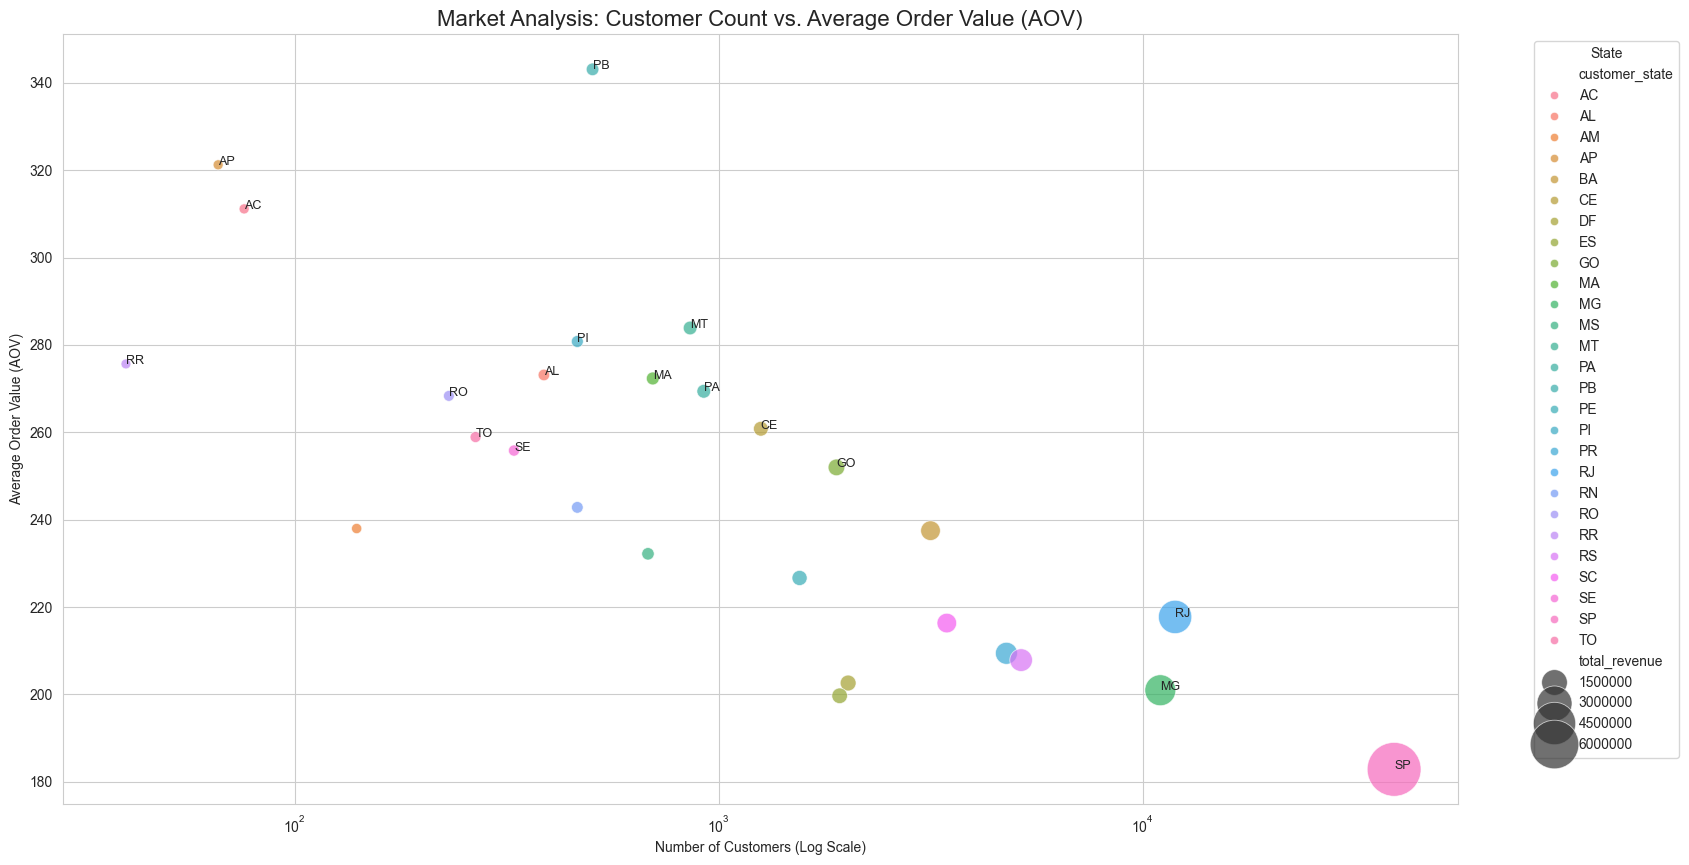

In [3]:
# --- 2. Geographic Analysis ---
print("\n--- Starting Geographic Analysis ---")
# Calculate total payment value per order
payment_cols = ['boleto', 'credit_card', 'debit_card', 'voucher']
# Ensure payment columns exist before summing
existing_payment_cols = [col for col in payment_cols if col in df.columns]
df['total_payment'] = df[existing_payment_cols].sum(axis=1)

# Group by state
geo_analysis = df.groupby('customer_state').agg(
    customer_count=('customer_unique_id', 'nunique'),
    order_count=('order_id', 'nunique'),
    total_revenue=('total_payment', 'sum')
).reset_index()

# Calculate Average Order Value (AOV)
geo_analysis['aov'] = geo_analysis['total_revenue'] / geo_analysis['order_count']

# Visualize the markets
plt.figure(figsize=(18, 10))
sns.scatterplot(data=geo_analysis, x='customer_count', y='aov', hue='customer_state', size='total_revenue', sizes=(50, 1500), alpha=0.7)

# Add labels for key states
for i, row in geo_analysis.iterrows():
    if row['customer_state'] in ['SP', 'RJ', 'MG'] or row['aov'] > 250 or row['customer_count'] > 10000:
        plt.text(row['customer_count'], row['aov'], row['customer_state'], fontsize=9)

plt.xscale('log') # Use log scale for better visualization of customer count
plt.title('Market Analysis: Customer Count vs. Average Order Value (AOV)', fontsize=16)
plt.xlabel('Number of Customers (Log Scale)')
plt.ylabel('Average Order Value (AOV)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

print("Displaying Geographic Analysis Plot...")
print("Insights:")
print("- Top-Right (High AOV, High Customers): Core markets like SP.")
print("- Top-Left (High AOV, Low Customers): Potential markets with high-value customers.")
print("- Bottom-Right (Low AOV, High Customers): Saturated markets, focus on increasing AOV.")
plt.show()

In [4]:
# --- 3. Purchase Behavior Analysis ---
print("\n--- Starting Purchase Behavior Analysis ---")

# 3.1 Repurchase Cycle Analysis
print("Calculating Repurchase Cycle...")
# Merge orders with customers to get customer_unique_id
repurchase_df = pd.merge(orders, df[['order_id', 'customer_unique_id']].drop_duplicates(), on='order_id')
repurchase_df['order_purchase_timestamp'] = pd.to_datetime(repurchase_df['order_purchase_timestamp'])

# Sort by customer and purchase date
repurchase_df = repurchase_df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])

# Calculate time difference between consecutive orders
repurchase_df['repurchase_days'] = repurchase_df.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# Calculate the average repurchase cycle
avg_repurchase_cycle = repurchase_df['repurchase_days'].mean()

print(f"Average Repurchase Cycle: {avg_repurchase_cycle:.2f} days")

# 3.2 Market Basket Analysis
print("\nPerforming Market Basket Analysis...")
# The main 'df' from the processed CSV already contains the necessary columns
# (order_id, product_id, product_category_name_english), so we use it directly.
basket_df = df

# For this analysis, we focus on orders with more than one item
multi_item_orders = basket_df.groupby('order_id')['product_id'].nunique()
multi_item_orders = multi_item_orders[multi_item_orders > 1].index
basket_df = basket_df[basket_df['order_id'].isin(multi_item_orders)]

# Create a list of lists, where each inner list is a transaction
transactions = basket_df.groupby('order_id')['product_category_name_english'].apply(list).values.tolist()

# Use TransactionEncoder to transform the data into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_onehot, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

print("\nTop 10 Association Rules (Potential for Bundling/Cross-selling):")
print(rules.sort_values(by='lift', ascending=False).head(10))



--- Starting Purchase Behavior Analysis ---
Calculating Repurchase Cycle...
Average Repurchase Cycle: 78.72 days

Performing Market Basket Analysis...

Top 10 Association Rules (Potential for Bundling/Cross-selling):
        antecedents       consequents  antecedent support  consequent support  \
0    (home confort)  (bed bath table)            0.018136            0.247967   
1  (bed bath table)    (home confort)            0.247967            0.018136   

    support  confidence      lift  representativity  leverage  conviction  \
0  0.013446    0.741379  2.989825               1.0  0.008949    2.907859   
1  0.013446    0.054224  2.989825               1.0  0.008949    1.038157   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.677826  0.053218   0.656104    0.397802  
1       0.884978  0.053218   0.036755    0.397802  


In [5]:
# --- 4. Sentiment Analysis (Proxy Method) ---
print("\n--- Starting Sentiment Analysis (Proxy Method) ---")
# Merge reviews with the main dataframe to link reviews to product categories
reviews_with_comments = order_reviews[['order_id', 'review_comment_message']].dropna()
df_with_comments = pd.merge(df, reviews_with_comments, on='order_id', how='inner')

# We analyze sentiment by proxy: using the review_score_mean
sentiment_by_category = df_with_comments.groupby('product_category_name_english')['review_score_mean'].mean().sort_values()

print("\nAverage Review Score by Product Category (Lowest First):")
print(sentiment_by_category.head(10))

print("\n--- Sentiment Analysis - Key Challenge & Next Steps ---")
print("Challenge: Review comments are in Portuguese. Direct sentiment analysis requires specialized NLP models.")
print("Proxy Analysis: Using the average review score is a practical first step to identify problem areas.")
print("Next Steps Suggestions:")
print("1. Use a Portuguese-specific library like textblob-pt.")
print("2. Use a translation API to translate comments to English first.")
print("3. Use a powerful multilingual model from a library like Hugging Face Transformers.")

print("\nAnalysis script finished.")



--- Starting Sentiment Analysis (Proxy Method) ---

Average Review Score by Product Category (Lowest First):
product_category_name_english
diapers and hygiene                        2.166667
security and services                      2.500000
office furniture                           2.921021
la cuisine                                 3.000000
fixed telephony                            3.274809
fashion male clothing                      3.304348
kitchen dining laundry garden furniture    3.315789
furniture living room                      3.345361
unknown                                    3.370753
home construction                          3.377593
Name: review_score_mean, dtype: float64

--- Sentiment Analysis - Key Challenge & Next Steps ---
Challenge: Review comments are in Portuguese. Direct sentiment analysis requires specialized NLP models.
Proxy Analysis: Using the average review score is a practical first step to identify problem areas.
Next Steps Suggestions:
1. Use a Portu